# Восстановление золота из руды

Цель: подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.
Спецификации модели:
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды с использованием данных с параметрами добычи и очистки. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Задачи:
1. Подготовить данные
1.1 Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака.
1.2. Проанализировать признаки, недоступные в тестовой выборке.
1.3. Провести предобработку данных.

2. Проанализировать данные
2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках.
2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

3. Построить модель
3.1. Написать функцию для вычисления итоговой sMAPE.
3.2. Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a>

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

from sklearn.metrics import make_scorer

import seaborn as sns

Пояснения к столбцам таблиц


Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

Xanthate **— ксантогенат (промотер, или активатор флотации);

Sulphate — сульфат (на данном производстве сульфид натрия);

Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

Параметры этапов


air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

    rougher — флотация
    
    primary_cleaner — первичная очистка
    
    secondary_cleaner — вторичная очистка
    
    final — финальные характеристики

Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    
    output — параметры продукта
    
    state — параметры, характеризующие текущее состояние этапа
    
    calculation — расчётные характеристики

In [2]:
test_data = pd.read_csv("/datasets/gold_recovery_test_new.csv")
#test_data.info() пока убрала, чтобы меньше времени тратилось на код
print('Количество пропусков в каждом столбце', test_data.isna().mean())
test_data.describe()

Количество пропусков в каждом столбце date                                          0.000000
primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.depressant              0.000945
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.000756
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.000567
rougher.input.feed_size                       0.000189
rougher.input.feed_sol     

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [3]:
train_data = pd.read_csv("/datasets/gold_recovery_train_new.csv")
#train_data.info() пока убрала, чтобы меньше времени тратилось на код
print('Количество пропусков в каждом столбце', train_data.isna().mean())
train_data.describe()

Количество пропусков в каждом столбце date                                          0.000000
final.output.concentrate_ag                   0.000071
final.output.concentrate_pb                   0.000071
final.output.concentrate_sol                  0.014913
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.000071
secondary_cleaner.state.floatbank5_b_air      0.000071
secondary_cleaner.state.floatbank5_b_level    0.000071
secondary_cleaner.state.floatbank6_a_air      0.000141
secondary_cleaner.state.floatbank6_a_level    0.000071
Length: 87, dtype: float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [4]:
full_data = pd.read_csv("/datasets/gold_recovery_full_new.csv")
#full_data.info() пока убрала, чтобы меньше времени тратилось на код
print('Количество пропусков в каждом столбце', full_data.isna().mean())
full_data.describe() 

Количество пропусков в каждом столбце date                                          0.000000
final.output.concentrate_ag                   0.000051
final.output.concentrate_pb                   0.000051
final.output.concentrate_sol                  0.010854
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.000051
secondary_cleaner.state.floatbank5_b_air      0.000051
secondary_cleaner.state.floatbank5_b_level    0.000051
secondary_cleaner.state.floatbank6_a_air      0.000103
secondary_cleaner.state.floatbank6_a_level    0.000051
Length: 87, dtype: float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Предобработка

In [5]:
datasets = [train_data, test_data, full_data]
for dataset in datasets:
    dataset["date"] = pd.to_datetime(dataset["date"]) # приведем ΄столбцы с датами к нужному формату
    print("число строк и колонок:", dataset.shape)
    print("пропуски", dataset.isna().sum().sum())
    print("дупликаты:", dataset.duplicated().sum())    

число строк и колонок: (14149, 87)
пропуски 4100
дупликаты: 0
число строк и колонок: (5290, 53)
пропуски 90
дупликаты: 0
число строк и колонок: (19439, 87)
пропуски 4481
дупликаты: 0


In [6]:
#Обработаем пропуски в столбцах, связанных с добычей золота:
train_data.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                   'rougher.output.tail_au','rougher.output.recovery'], inplace=True)
#Посмотрим, что получилось в результате:
#train_data.info() пока убрала, чтобы меньше времени тратилось на код

In [7]:
# Отсутствующие столбцы в test_data
missing_columns = list(set(train_data.columns) - set(test_data.columns))
display(missing_columns)
# Отсутствующие столбцы в train_data
missing_columns_a = list(set(full_data.columns) - set(train_data.columns))
display(missing_columns_a)

['final.output.concentrate_sol',
 'rougher.output.tail_ag',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'final.output.tail_pb',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.tail_au',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'rougher.output.tail_sol',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_pb',
 'rougher.output.concentrate_ag',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.tail_pb',
 'final.output.tail_au',
 'rougher.output.recovery',
 'rougher.output.concentrate_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_au',
 'primary_cleaner.output.tail_pb',
 'final.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'secondary_cleaner.output.tai

[]

In [8]:
#подготовим тестовую выборку к использованию в моделях:
test_data = test_data.dropna(subset= ['date'],axis = 0)
test_for_target = test_data.merge(full_data.loc[:,['date',"rougher.output.recovery","final.output.recovery"]],on = 'date')
test_for_target = test_for_target.dropna(subset=["rougher.output.recovery","final.output.recovery"],axis = 0)
test_data = test_for_target.loc[:,test_data.columns]
#используем метод KNNImputer() для пополнения тестовой выборки
test_data = test_data.drop("date",axis =1)
imputer = KNNImputer()
test_without_nan = pd.DataFrame(data = imputer.fit_transform(test_data),
             columns= test_data.columns,
             index = test_data.index)

Набор столбцов в тестовой выборке меньше всех, в полной и тренировочной наборы совпадают. При этом отсутствуют параметры, которые обозначают характеристики этапов обработки

In [9]:
def MAE_au(data):
    concentrate_au = data['rougher.output.concentrate_au']
    feed_au = data['rougher.input.feed_au']
    tail_au = data['rougher.output.tail_au']
    in_data_recovery = data['rougher.output.recovery']
    calculated_recovery = concentrate_au * (feed_au - tail_au) / feed_au/ (concentrate_au - tail_au) * 100
    return MAE(in_data_recovery, calculated_recovery)
print('Абсолютная средняя ошибка по полной выборке =', MAE_au(full_data))
print('Абсолютная средняя ошибка по тренировочной выборке =', MAE_au(train_data))
#print('Абсолютная средняя ошибка по тестовой выборке =', MAE_au(test_data)) так как отсутствует столбец 'rougher.output.concentrate_au'
#то нет возможности посчитать для этой выборки этот показатель.

Абсолютная средняя ошибка по полной выборке = 1.0894863727510426e-14
Абсолютная средняя ошибка по тренировочной выборке = 1.0748911125799084e-14


In [10]:
display(train_data.describe())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


## Анализ данных

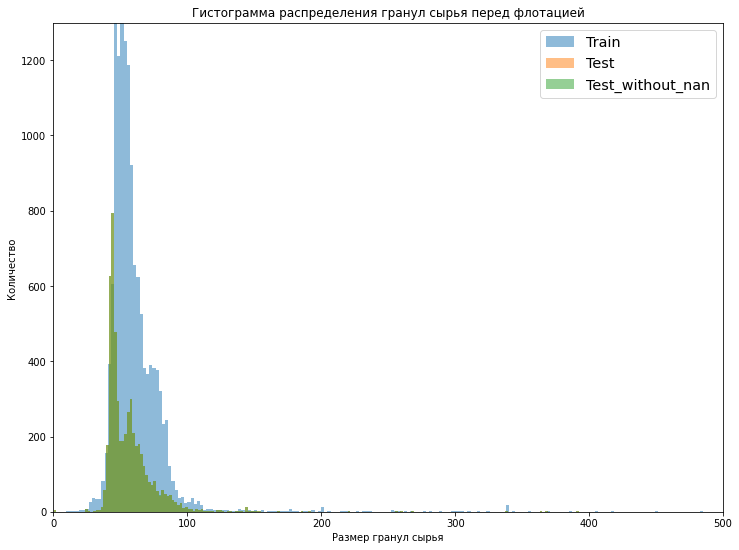

In [11]:
plt.figure(figsize=[12,9])

plt.hist(train_data['rougher.input.feed_size'], bins=200, label = 'Train', alpha=.5)
plt.hist(test_data['rougher.input.feed_size'], bins=200, label = 'Test', alpha=.5)
plt.hist(test_without_nan['rougher.input.feed_size'], bins=200, label = 'Test_without_nan', alpha=.5)

plt.xlim([0, 500])
plt.ylim([0, 1300])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения гранул сырья перед флотацией")
plt.show()

Гистограммы распределения размера гранул сырья в двух выборках, тестовой и тренировочной, фактически совпадают по своему виду, за исключением числа данных

Посмотрим на концентрацию металов на каждом из этапов

Концентрация до флотации
Концентрация Серебра: 8.58, Свинца: 3.52, Золота: 7.87


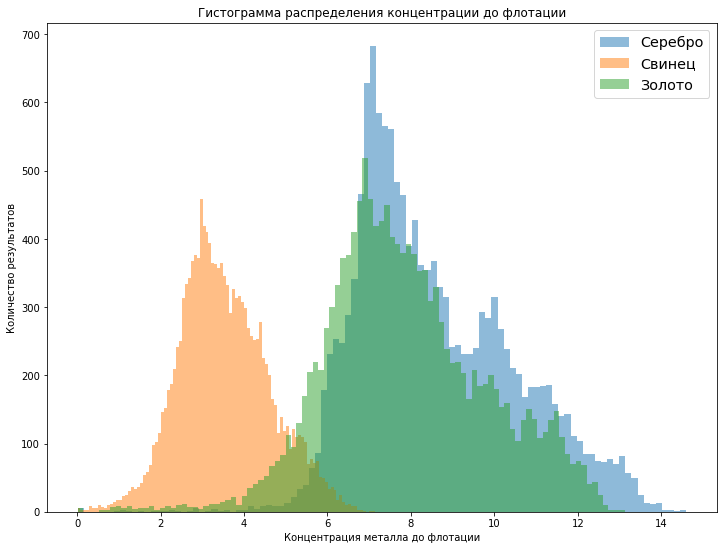

In [12]:
print("Концентрация до флотации")
print("Концентрация Серебра:{: 0.2f}, Свинца:{: 0.2f}, Золота:{: 0.2f}".
format(train_data['rougher.input.feed_ag'].mean(),
train_data['rougher.input.feed_pb'].mean(),
train_data['rougher.input.feed_au'].mean()))

plt.figure(figsize=[12,9])
plt.hist(train_data['rougher.input.feed_ag'], bins=100, label = 'Серебро', alpha=.5)
plt.hist(train_data['rougher.input.feed_pb'], bins=100, label = 'Свинец', alpha=.5)
plt.hist(train_data['rougher.input.feed_au'], bins=100, label = 'Золото', alpha=.5)

plt.xlabel("Концентрация металла до флотации")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения концентрации до флотации")
plt.show()

Концентрация после флотации
Коцентрация Серебра: 11.78, Свинца: 7.66, Золота: 19.44


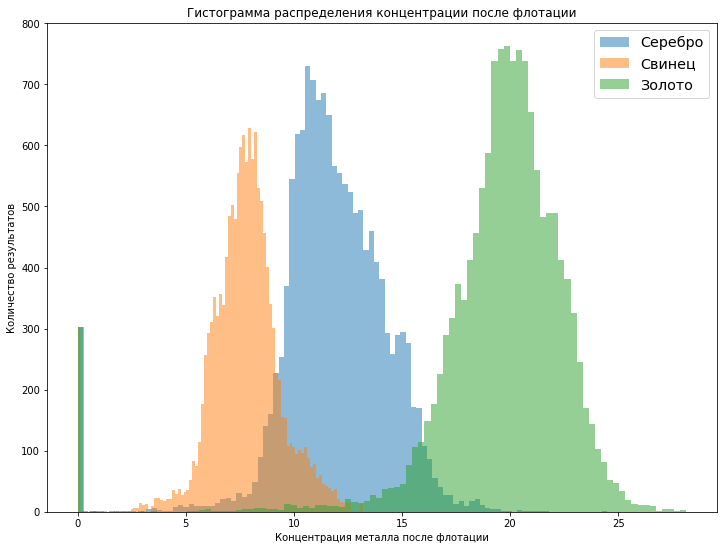

In [13]:
print("Концентрация после флотации")
print("Коцентрация Серебра:{: 0.2f}, Свинца:{: 0.2f}, Золота:{: 0.2f}".
format(train_data["rougher.output.concentrate_ag"].mean(),
train_data["rougher.output.concentrate_pb"].mean(),
train_data["rougher.output.concentrate_au"].mean()))

plt.figure(figsize=[12,9])
plt.hist(train_data['rougher.output.concentrate_ag'], bins=100, label = 'Серебро', alpha=.5)
plt.hist(train_data['rougher.output.concentrate_pb'], bins=100, label = 'Свинец', alpha=.5)
plt.hist(train_data['rougher.output.concentrate_au'], bins=100, label = 'Золото', alpha=.5)

plt.xlabel("Концентрация металла после флотации")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения концентрации после флотации")
plt.show()

Концентрация после первичной очистки
Концентрация Серебра: 8.20, Свинца: 9.59, Золота: 32.39


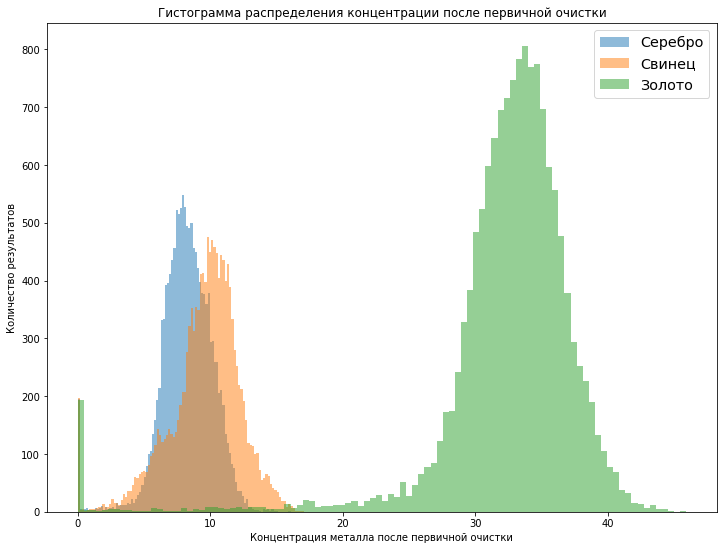

In [14]:
print("Концентрация после первичной очистки")
print("Концентрация Серебра:{: 0.2f}, Свинца:{: 0.2f}, Золота:{: 0.2f}".
format(train_data["primary_cleaner.output.concentrate_ag"].mean(),
train_data["primary_cleaner.output.concentrate_pb"].mean(),
train_data["primary_cleaner.output.concentrate_au"].mean()))


plt.figure(figsize=[12,9])
plt.hist(train_data['primary_cleaner.output.concentrate_ag'], bins=100, label = 'Серебро', alpha=.5)
plt.hist(train_data['primary_cleaner.output.concentrate_pb'], bins=100, label = 'Свинец', alpha=.5)
plt.hist(train_data['primary_cleaner.output.concentrate_au'], bins=100, label = 'Золото', alpha=.5)

plt.xlabel("Концентрация металла после первичной очистки")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения концентрации после первичной очистки")
plt.show()

Концентрация после вторичной очистки
Концентрация Серебра: 5.14, Свинца: 10.13, Золота: 44.00


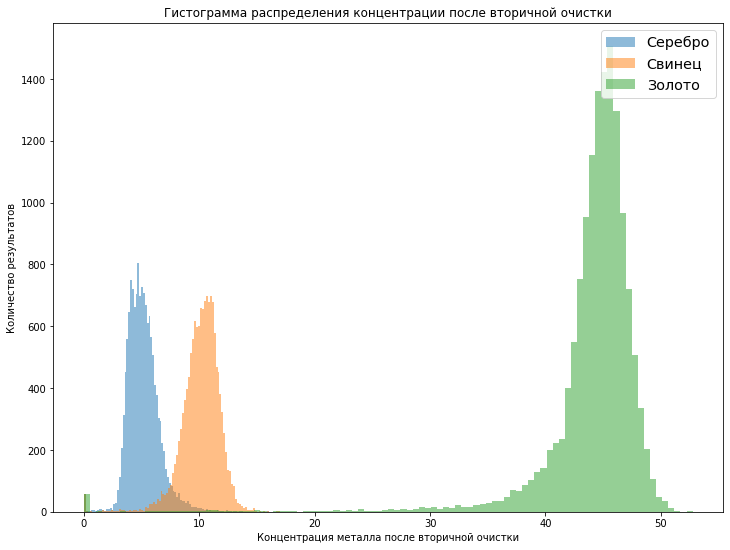

In [15]:
print("Концентрация после вторичной очистки")
print("Концентрация Серебра:{: 0.2f}, Свинца:{: 0.2f}, Золота:{: 0.2f}".
format(train_data["final.output.concentrate_ag"].mean(),
train_data["final.output.concentrate_pb"].mean(),
train_data["final.output.concentrate_au"].mean()))

plt.figure(figsize=[12,9])
plt.hist(train_data['final.output.concentrate_ag'], bins=100, label = 'Серебро', alpha=.5)
plt.hist(train_data['final.output.concentrate_pb'], bins=100, label = 'Свинец', alpha=.5)
plt.hist(train_data['final.output.concentrate_au'], bins=100, label = 'Золото', alpha=.5)

plt.xlabel("Концентрация металла после вторичной очистки")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма распределения концентрации после вторичной очистки")
plt.show()

У золота и свинца концентрация после каждого этапа увеличивается, у серебра после второго этапа увеличивается, а в результате очисток падает ниже первоначального показателя. Видимо, часть металла теряется в процессе реакций с веществами, которые используют для очистки

In [16]:
train_without_nan = pd.DataFrame(data = imputer.fit_transform(train_data.drop(['date'],axis = 1)),
             columns= train_data.drop(['date'],axis = 1).columns,
             index = train_data.index)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["rougher.input.feed_au"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["rougher.input.feed_ag"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["rougher.input.feed_pb"] < 1].index,
                               axis = 0)


train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["rougher.output.concentrate_au"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["rougher.output.concentrate_ag"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["rougher.output.concentrate_pb"] < 1].index,
                               axis = 0)


train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["primary_cleaner.output.concentrate_au"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["primary_cleaner.output.concentrate_ag"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["primary_cleaner.output.concentrate_pb"] < 1].index,
                               axis = 0)

train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["final.output.concentrate_au"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["final.output.concentrate_ag"] < 1].index,
                               axis = 0)
train_without_nan = train_without_nan.drop(index = train_without_nan[train_without_nan["final.output.concentrate_pb"] < 1].index,
                               axis = 0)

In [17]:
def sum_concentrate(data):
    sum_conc = pd.DataFrame()
    before_rougher = 'rougher.input.feed_'
    rougher = 'rougher.output.concentrate_'
    primary_cleaner = 'primary_cleaner.output.concentrate_'
    final = 'final.output.concentrate_'

    sum_conc['before_rougher'] = data[[before_rougher+'au', before_rougher+'ag', before_rougher+'pb', before_rougher+'sol']].sum(axis=1)
    sum_conc['rougher'] = data[[rougher+'au', rougher+'ag', rougher+'pb', rougher+'sol']].sum(axis=1)
    sum_conc['primary_cleaner'] = data[[primary_cleaner+'au', primary_cleaner+'ag', primary_cleaner+'pb', primary_cleaner+'sol']].sum(axis=1)
    sum_conc['final'] = data[[final+'au', final+'ag', final+'pb', final+'sol']].sum(axis=1)
    return sum_conc

sums_train = sum_concentrate(train_without_nan)
display(sums_train.sample(10))

,before_rougher,rougher,primary_cleaner,final
13493,53.496205,70.081175,53.232884,67.321190
10657,64.463987,72.706944,63.949023,69.998698
1116,40.614049,55.509740,63.840641,65.753213
6937,62.757573,68.172858,54.656037,72.056141
2466,61.676525,79.789116,72.163149,70.347943
529,47.141239,69.836306,69.439121,70.971021
2818,45.456822,77.132353,55.986417,67.934697
11196,57.636691,65.892857,60.805993,68.977822
5627,58.965363,75.012293,61.827760,75.378683
2406,56.629751,81.559911,68.831487,69.326423


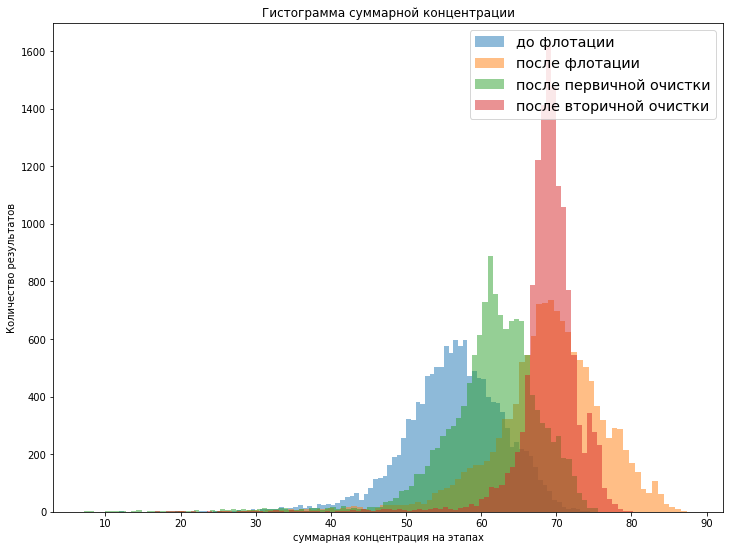

In [18]:
plt.figure(figsize=[12,9])
plt.hist(sums_train['before_rougher'], bins=100, label = 'до флотации', alpha=.5)
plt.hist(sums_train['rougher'], bins=100, label = 'после флотации', alpha=.5)
plt.hist(sums_train['primary_cleaner'], bins=100, label = 'после первичной очистки', alpha=.5)
plt.hist(sums_train['final'], bins=100, label = 'после вторичной очистки', alpha=.5)

plt.xlabel("суммарная концентрация на этапах")
plt.ylabel("Количество результатов")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Гистограмма суммарной концентрации")
plt.show()

Изучены концетрации основных веществ на разных этапах очистки и представлены в виде графиков

Размер гранул тестовой и обучающей выборки на начальном этапе представлен в виде графика.

Создана таблица суммарной концентрации веществ на разных этапах.

## Модель

Целевые признаки:

rougher.output.recovery эффективность обогащения чернового концентрата;
    
final.output.recovery эффективность обогащения финального концентрата 

Функция для расчета sMAPE

sMAPE=1N∑i=1N|yi−yi^|(|yi|+|yi^|)/2×100

где:

yi
— значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
yi^ — значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
N — количество объектов в выборке
∑Ni=1 — суммирование по всем объектам выборки (i меняется от 1 до N).

In [19]:
#подготовим данные к модели
good_train_data = train_without_nan.dropna()
good_train_data.isna().mean()

final.output.concentrate_ag                   0.0
final.output.concentrate_pb                   0.0
final.output.concentrate_sol                  0.0
final.output.concentrate_au                   0.0
final.output.recovery                         0.0
                                             ... 
secondary_cleaner.state.floatbank5_a_level    0.0
secondary_cleaner.state.floatbank5_b_air      0.0
secondary_cleaner.state.floatbank5_b_level    0.0
secondary_cleaner.state.floatbank6_a_air      0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 86, dtype: float64

In [20]:
good_test_data = test_without_nan.dropna()
good_test_data.isna().mean()
features_columns = good_test_data.columns[1:]
rougher_features_columns = set(features_columns[12:34])
final_features_columns = set(features_columns)
#display(rougher_features_columns) скрыла, чтобы быстрее код работал
#display(final_features_columns) скрыла, чтобы быстрее код работал

In [21]:
# Подготовка признаков для final.output.recovery
columns_to_delete = set(good_train_data.columns) - final_features_columns
#print(columns_to_delete)
train_features_final = good_train_data.drop(columns_to_delete, axis=1)
#print(train_features_final.columns) скрыла, чтобы быстрее код работал

# Подготовка признаков для rougher.output.recovery
columns_to_delete = set(train_features_final.columns) - rougher_features_columns
#print(columns_to_delete) скрыла, чтобы быстрее код работал
train_features_rougher = train_features_final.drop(columns_to_delete, axis=1)
#print(train_features_rougher.columns) скрыла, чтобы быстрее код работал

Целевые признаки

In [22]:
train_target_final = good_train_data['final.output.recovery']
train_target_rougher = good_train_data['rougher.output.recovery']

In [23]:
#Признаки тестовой выборки
test_target_rougher = test_for_target["rougher.output.recovery"]
test_target_final = test_for_target["final.output.recovery"]
columns_to_delete = set(test_without_nan.columns) - final_features_columns
test_features_final = test_without_nan.drop(columns_to_delete, axis=1)
columns_to_delete = set(test_features_final.columns) - rougher_features_columns
test_features_rougher = test_features_final.drop(columns_to_delete, axis=1)

In [24]:
#Посмотрим, какие параметры подходят выбранным типам моделей:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [25]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [26]:
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [27]:
def sMAPE(target, predictions):
    summa = (abs(predictions - target) / ((abs(target) + abs(predictions)) / 2)).sum()
    smape = (1 / len(target)) * summa * 100
    return smape

In [28]:
def sMAPEfinal(rougher, final):
    smape_final_1 = 0.25 * rougher + 0.75 * final
    return smape_final_1

In [29]:
my_scorer = make_scorer(sMAPE, greater_is_better=True)

In [30]:
# # Посмотрим на поведение моделей (RandomForestRegressor(), DecisionTreeRegressor()): к сожалению, не хочет автоматом считать, висит 
# # Зададим границы параметров для способа GridSearchCV поиска лучшей модели:
# def model_teaching (model, parametrs, features, target):
#     grid = GridSearchCV(model, parametrs, scoring=my_scorer)
#     grid.fit(features, target)
#     return grid.best_params_

In [31]:
%time
model = LinearRegression()
print('Mean R2 from CV of LinearRegression =', cross_val_score(model, train_features_final,
                                                            train_target_final, cv=5).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(model, train_features_rougher,
                                        train_target_rougher, cv=5, scoring=my_scorer).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(model, train_features_final,
                                              train_target_final, cv=5, scoring=my_scorer).mean())

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
Mean R2 from CV of LinearRegression = -0.17458109168892058
Mean MAE from CV of LinearRegression = 6.82938596512015
Mean MAE from CV of LinearRegression = 10.825620606932198


In [32]:
model = DecisionTreeRegressor()
print('Mean R2 from CV of DecisionTreeRegressor =', cross_val_score(model, train_features_final,
                                                                train_target_final, cv=5).mean())
print('Mean MAE from CV of DecisionTreeRegressor =', cross_val_score(model, train_features_rougher,
                                    train_target_rougher, cv=5, scoring=my_scorer).mean())
print('Mean MAE from CV of DecisionTreeRegressor =', cross_val_score(model, train_features_final,
                                    train_target_final, cv=5, scoring=my_scorer).mean())

Mean R2 from CV of DecisionTreeRegressor = -1.8865717035598977
Mean MAE from CV of DecisionTreeRegressor = 9.2329084670634
Mean MAE from CV of DecisionTreeRegressor = 16.755450471080866


In [33]:
model = RandomForestRegressor()
print('Mean R2 from CV of RandomForestRegressor =', cross_val_score(model, train_features_final,
                                                    train_target_final, cv=5).mean())
print('Mean MAE from CV of RandomForestRegressor =', cross_val_score(model, train_features_rougher,
                                        train_target_rougher, cv=5, scoring=my_scorer).mean())
print('Mean MAE from CV of RandomForestRegressor =', cross_val_score(model, train_features_final,
                                        train_target_final, cv=5, scoring=my_scorer).mean())

Mean R2 from CV of RandomForestRegressor = 0.042345474295718
Mean MAE from CV of RandomForestRegressor = 6.989995662614708
Mean MAE from CV of RandomForestRegressor = 9.550949377357046


In [34]:
#Проверим, влияет масштабирование данных на результат
%time
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('Mean R2 from CV of LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(pipeline, train_features_rougher, train_target_rougher, cv=5, 
                                                               scoring=my_scorer).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5, 
                                                                scoring=my_scorer).mean())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Mean R2 from CV of LinearRegression = -0.17458109168891947
Mean MAE from CV of LinearRegression = 6.829385965120148
Mean MAE from CV of LinearRegression = 10.825620606932194


Масштабирование данных на результат не повлияло, значит, и для других моделей можно им пренебречь.

Сделаем функцию кросс-валидации для определения лучшей модели.

Как мы видим, LinearRegression() показывает лучший результат.

Посмотрим, какая из моделей даст лучший результат по sMAPE с учетом перебора гиперпараметров, где это возможно

In [35]:
%time
best_est = 0
best_smape=10
for est in range(25, 35):
    model_rfr = RandomForestRegressor(random_state=12345, n_estimators=est) 
    smape = cross_val_score(model_rfr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
    if smape < best_smape:
        best_est = est
        best_smape = smape

print('Лучшее количество деревьев', best_est,'Лучшая smape', best_smape)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 7.87 µs
Лучшее количество деревьев 25 Лучшая smape 6.966035062911388


In [36]:
%time
best_smape = 10
best_depth = 0
for depth in range(1, 10):
    model_rfr = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth=depth) 
    smape = cross_val_score(model_rfr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
    if smape < best_smape:
        best_smape = smape
        best_depth = depth
print('Лучшая глубина дерева', best_depth, "Лучшая smape:", best_smape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Лучшая глубина дерева 3 Лучшая smape: 6.658958057926282


In [37]:
%time
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth=3) 
smape = cross_val_score(model_rfr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
print(smape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
6.658958057926282


In [38]:
%time
best_smape = 10
best_depth = 0
for depth in range(1, 20):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    smape = cross_val_score(model_dtr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
    if smape < best_smape:
        best_smape = smape
        best_depth = depth
print('Лучшая глубина дерева', best_depth, "Лучшая smape:", best_smape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Лучшая глубина дерева 2 Лучшая smape: 6.848421486002094


In [39]:
%time
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=2) # обучим модель с заданной глубиной дерева
smape = cross_val_score(model_dtr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
print(smape)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
6.848421486002094


In [40]:
%time
#Посмотрим результат на третьей модели:
model_lr = LinearRegression(normalize=False, positive = False)
smape = cross_val_score(model_lr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
print(smape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
6.82938596512015


In [41]:
%time
model_lr = LinearRegression(normalize=False, positive = True)
smape = cross_val_score(model_lr, train_features_rougher, train_target_rougher, cv=5,
                                                                scoring=my_scorer).mean()
print(smape)

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 8.82 µs
6.622023914131742


Таким образом, лучшая модель из всех трех LinearRegression(). Посмотрим, как она себя поведет на итоговом целевом признаке.

In [42]:
#my_scorer_final = make_scorer(sMAPEfinal, greater_is_better=True)

In [57]:
%time
best_est = 0
best_smape=11
for est in range(50, 60):
    model_rfr = RandomForestRegressor(random_state=12345, n_estimators=est) 
    smapefinal = cross_val_score(model_rfr, train_features_final, train_target_final, cv=3,
                                                                scoring=my_scorer).mean()
    if smapefinal < best_smape:
        best_est = est
        best_smape = smapefinal
print('Лучшее количество деревьев', best_est,'Лучшая smape', best_smape)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Лучшее количество деревьев 57 Лучшая smape 10.48735537647115


In [58]:
%time
best_smape = 10
best_depth = 0
for depth in range(1, 20):
    model_rfr = RandomForestRegressor(random_state=12345, n_estimators= 57, max_depth=depth) 
    smapefinal = cross_val_score(model_rfr, train_features_final, train_target_final, cv=5,
                                                                scoring=my_scorer).mean()
    if smapefinal < best_smape:
        best_smape = smapefinal
        best_depth = depth
print('Лучшая глубина дерева', best_depth, "Лучшая smape:", best_smape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Лучшая глубина дерева 1 Лучшая smape: 9.360555450246625


In [45]:
%time
best_smape = 10
best_depth = 0
for depth in range(1, 20):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    smapefinal = cross_val_score(model_dtr, train_features_final, train_target_final, cv=5,
                                                                scoring=my_scorer).mean()
    if smapefinal < best_smape:
        best_smape = smapefinal
        best_depth = depth
print('Лучшая глубина дерева', best_depth, "Лучшая smape:", best_smape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Лучшая глубина дерева 1 Лучшая smape: 9.360679128049886


In [46]:
%time
model_lr = LinearRegression(normalize=False, positive = True)
smapefinal = cross_val_score(model_lr, train_features_final, train_target_final, cv=5,
                                                                scoring=my_scorer).mean()
print(smapefinal)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
9.745442057962514


Проверим результат на тестовой выборке

In [47]:
%time
model_lr = LinearRegression(normalize=False, positive = True)
model_lr.fit(train_features_rougher, train_target_rougher)
preds_rough_lr = model_lr.predict(test_features_rougher)
rougher = sMAPE(preds_rough_lr, test_target_rougher)
print('sMAPE на тестовой выборке', rougher)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.48 µs
sMAPE на тестовой выборке 8.063902395250446


In [48]:
%time
model_lr = LinearRegression(normalize=False, positive = True)
model_lr.fit(train_features_final, train_target_final)
preds_final_lr = model_lr.predict(test_features_final) # получим предсказания модели
final = sMAPE(preds_final_lr, test_target_final)
smapefinal = sMAPEfinal(rougher, final)
print('sMAPEfinal на тестовой выборке', smapefinal)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
sMAPEfinal на тестовой выборке 8.99855954969781


In [59]:
%time
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth=3) 
model_rfr.fit(train_features_rougher, train_target_rougher)
preds_rough_rfr = model_rfr.predict(test_features_rougher)
rougher = sMAPE(preds_rough_rfr, test_target_rougher)
print('sMAPE на тестовой выборке', rougher)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
sMAPE на тестовой выборке 8.94876150849763


In [60]:
%time
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=57, max_depth=1) # обучим модель с заданной глубиной дерева
model_rfr.fit(train_features_final, train_target_final) # обучим модель
preds_final_rfr = model_rfr.predict(test_features_final) # получим предсказания модели
final = sMAPE(preds_final_rfr, test_target_final)
smapefinal = sMAPEfinal(rougher, final) # посчитаем качество модели
print('sMAPEfinal на тестовой выборке', smapefinal) 

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
sMAPEfinal на тестовой выборке 9.418584108553386


Выводы:
Проанализированы выборки, обнаружены столбцы, отсутствующие в тестовой выборке. Для дальнейшей работы, тестовая выборка была скорректирована.

Эффективность обогащения рассчитана правильно, она была сравнена с вычислениями ее на обучающей выборке для признака 
rougher.output.recovery. Абсолютная средняя ошибка по тренировочной выборке = 1.0748911125799084e-14

Изучены концетрации основных веществ на разных этапах очистки и представлены в виде графиков
Размер гранул тестовой и обучающей выборки на начальном этапе представлен в виде графика.
Создана таблица суммарной концентрации веществ на разных этапах.

У золота и свинца концентрация после каждого этапа увеличивается, у серебра после второго этапа увеличивается, а в результате очисток падает ниже первоначального показателя. Видимо, часть металла теряется в процессе реакций с веществами, которые используют для очистки

Создана функция для подсчета sMAPE для целевого признака train_target_rougher и итоговой sMAPE. Проанализированы показатели R2, MAE:

Mean R2 from CV of LinearRegression = -0.17458109168892058
Mean MAE from CV of LinearRegression = 6.82938596512015
Mean MAE from CV of LinearRegression = 10.825620606932198

Mean R2 from CV of DecisionTreeRegressor = -1.960313484276531
Mean MAE from CV of DecisionTreeRegressor = 9.229946514719604
Mean MAE from CV of DecisionTreeRegressor = 15.969075449486985

Mean R2 from CV of RandomForestRegressor = 0.051079076171925863
Mean MAE from CV of RandomForestRegressor = 7.009355682626632
Mean MAE from CV of RandomForestRegressor = 9.663341590725057

Масштабирование данных на результат LinearRegression не повлияло, значит, и для других моделей можно им пренебречь.

Данные кросс-валидации также были проверены на анализе, какая из  моделей даст лучший результат по sMAPE с учетом перебора гиперпараметров, где это возможно

Таким образом, лучшая модель из всех трех LinearRegression(), ее sMAPE составил 6.622023914131742, а sMAPE на final 9.745442057962514

А на тестовой выборке у LinearRegression() показатели такие: 
sMAPE на тестовой выборке 8.063902395250446
sMAPEfinal на тестовой выборке 8.99855954969781

Вторая по показателю RandomForestRegressor ее sMAPE составил , а sMAPE на final 9.360555450246625, что лучше, чем у лидера

Однако показатели на тестовой выборке у RandomForestRegressor хуже, чем у лидера: sMAPE на тестовой выборке 8.94876150849763 sMAPEfinal на тестовой выборке 9.418584108553386